In [1]:
import numpy as np
from scipy import linalg
from matplotlib import pyplot as plt

Implementación de los clasificadores lineales: SVM y Softmax

In [2]:
class LinearClassifier(object):
    def __init__(self, k):
        #k = número de clases
        self.k = k

    def load(self, X, y, normalize=False):
        self.X = self.clean(X, normalize)
        self.y = y
        self.s = self.X.shape[1]
        self.m = self.X.shape[0]

        self.W = np.random.uniform(-1, 1, size=(self.k, self.s))
    
    def reset(self):
        #Reseteo los pesos por si quiero hacer cross-validation
        self.W = np.random.uniform(-1, 1, size=(self.k, self.s))


    def clean(self, X, normalize):
        X_norm = X.reshape(len(X), X[0].size).astype(float)
        #Agrego el vector de unos
        ones = np.ones((X_norm.shape[0], 1))
        X_norm = np.concatenate((ones, X_norm), axis=1)

        if normalize:
            X_norm /= np.max(X.astype(float))

        return X_norm
    
    def predict(self, X, normalize=False):
        if(X.shape[1] != self.X.shape[1]):
            X = self.clean(X, normalize)
            
        return np.dot(self.W, X.T)

    def accuracy(self, yguess, ytrue):
        return float(np.sum(yguess==ytrue))/float(ytrue.size)

    def loss_grads(self, X, y, batch_size, lambda_=.1, *args, **kwargs):
        return None
    
    def train(self, batch_size, epochs=10, alpha=.001, lambda_=.1, verbose=True, epsilon=1e-2):
        loss_hist = []

        num_batches = int(self.m/batch_size)

        for epoch in range(epochs):

            for batch in range(num_batches):
                loss, grad = self.loss_grads(self.X[batch*batch_size:(batch+1)*batch_size,:], self.y[batch*batch_size:(batch+1)*batch_size], batch_size, lambda_)
                self.W += -alpha*grad
            
            loss_hist.append(loss)

            #Condición de estabilidad
            if epoch > 2 and abs(loss_hist[-1] - loss_hist[-2]) < epsilon:
                break
            
            if(verbose and epoch%10==0):
                print("Cost at epoch {}: {:.2f}".format(epoch, loss))

        return loss_hist
      
        

In [3]:
class SVM(LinearClassifier):
    def __init__(self, k, delta=1):
        super(SVM, self).__init__(k)
        self.delta = delta

    
    def loss_grads(self, X, y, batch_size, lambda_):
        #Scores tiene de tamaño k*batch_size
        scores = self.predict(X)
        idx = np.arange(0, y.size)

        resta = scores - scores[y, idx] + self.delta

        cost = np.sum(np.maximum(0, resta))/batch_size - self.delta

        L2 = linalg.norm(self.W[1:,:])**2
        loss = cost + lambda_/2 * L2

        grad = np.zeros_like(self.W)
        
        scores[resta>0] = 1
        scores[resta<=0] = 0
        #Seteo a 0 el score de y_i en cada columna para no sumarlo en la linea de abajo
        scores[y, idx] = 0
        scores[y, idx] = -np.sum(scores, axis=0)

        #scores*X es una multiplicacion de tipo (k*batch_size)*(batch_size*s) que es lo que quiero obtener
        grad = np.dot(scores, X)/batch_size
        grad += lambda_*self.W

        return loss, grad
        


In [4]:
class SoftMax(LinearClassifier):
    def __init__(self, k):
        super(SoftMax, self).__init__(k)

    def f(self, scores):
        C = np.max(scores)
        scores -= C
        return np.exp(scores)/np.sum(np.exp(scores), axis=0)

    
    def loss_grads(self, X, y, batch_size, lambda_):
        #Scores tiene de tamaño k*batch_size
        scores = self.predict(X)
        softmax_fun = self.f(scores)
        idx = np.arange(0, y.size)

        cost = np.sum(-np.log(softmax_fun[y, idx]))/batch_size
        
        L2 = linalg.norm(self.W[1:,:])**2
        loss = cost + lambda_/2 * L2

        #le resto la delta
        softmax_fun[y, idx] -= 1

        grad = np.zeros_like(self.W)

        grad = np.dot(softmax_fun, X)/batch_size
    
        grad += lambda_*self.W

        return loss, grad
        

In [59]:
#Testing
X = np.array([[1, 1, 0],
              [1, 3, 2],
              [-1, 0 ,1],
              [8, 1, 2]])
y = np.array([1, 0, 0, 2])
modelo = SoftMax(3)
modelo.load(X, y)
modelo.W.shape
modelo.loss_grads(X, y, 4)

(9.165843124778595,
 array([[-0.15080992,  2.82124687, -1.22656717, -0.42477943],
        [-1.00105709, -0.99296713,  0.14716708,  0.40998766],
        [-0.22459018, -2.42187279, -0.42881194, -1.24187111]]))

In [34]:
modelo.loss_grads(X, y, 4)

(4,)


(array([1.81272859, 1.81453935, 1.81439033, 0.81704448]),
 array([[-0.94940185,  0.58742029, -0.40718563, -0.69193415],
        [-0.53509172,  0.63979519, -0.41312201, -0.63708377],
        [ 0.90852285,  0.73765613, -0.99216981,  0.05651152]]))

Probemos fitear el MNIST

In [227]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()
 
#shape of dataset
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


Fiteamos primero el modelo SVM

In [229]:
model = SVM(10, delta=1)
model.load(train_X, train_y, normalize=True)

In [230]:
loss_hist = model.train(batch_size=128, epochs=100, lambda_=.1, alpha=.001)


Cost at epoch 0: 119.43
Cost at epoch 10: 42.40
Cost at epoch 20: 16.58
Cost at epoch 30: 6.63
Cost at epoch 40: 2.80
Cost at epoch 50: 1.33
Cost at epoch 60: 0.78
Cost at epoch 70: 0.57


In [231]:
preds = np.argmax(model.predict(test_X, normalize=True), axis=0)
print("Final test accuracy: {:.2f}%".format(100*model.accuracy(preds, test_y)))



Final test accuracy: 90.47%


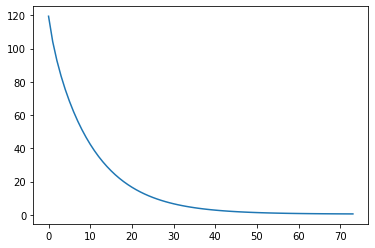

In [232]:
plt.plot(loss_hist);

Probemos ahora con el SoftMax

In [233]:
modelSM = SoftMax(10)
modelSM.load(train_X, train_y, normalize=True)

In [234]:
loss_hist_SM = modelSM.train(batch_size=128, epochs=200, alpha=.001, lambda_=.1, epsilon=1e-4)

Cost at epoch 0: 114.59
Cost at epoch 10: 43.28
Cost at epoch 20: 17.12
Cost at epoch 30: 7.09
Cost at epoch 40: 3.22
Cost at epoch 50: 1.72
Cost at epoch 60: 1.14
Cost at epoch 70: 0.92
Cost at epoch 80: 0.83
Cost at epoch 90: 0.80
Cost at epoch 100: 0.78
Cost at epoch 110: 0.78
Cost at epoch 120: 0.78


Final test accuracy: 86.94%


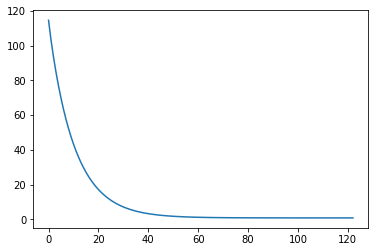

In [235]:
preds = np.argmax(modelSM.predict(test_X, normalize=True), axis=0)
print("Final test accuracy: {:.2f}%".format(100*modelSM.accuracy(preds, test_y)))
plt.plot(loss_hist_SM);

Fiteando CIFAR10

In [5]:
from keras.datasets import cifar10

# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [6]:
#Esto porque genera problemas
trainy = trainy[:,0]
testy = testy[:,0]
print(trainy.shape)

(50000,)


In [7]:
names_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 
              3: 'cat', 4: 'deer', 5: 'dog', 
              6: 'frog', 7: 'horse', 8: 'ship', 
              9: 'truck'}

Fiteando SVM a MNIST

In [27]:
cifarSVM = SVM(10, delta=1)
cifarSVM.load(trainX, trainy, normalize=True)

In [17]:
%timeit cifarSVM.train(batch_size=128, epochs=1, alpha=.01, lambda_=.1, verbose=True)

Cost at epoch 0: 118.36
Cost at epoch 0: 57.28
Cost at epoch 0: 30.82
Cost at epoch 0: 18.03
Cost at epoch 0: 12.70
Cost at epoch 0: 10.95
Cost at epoch 0: 8.91
Cost at epoch 0: 8.77
1.26 s ± 33.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
loss_cifarSVM = cifarSVM.train(batch_size=256, epochs=200, alpha=.003, lambda_=.1, verbose=True)

Cost at epoch 0: 430.64
Cost at epoch 10: 132.02
Cost at epoch 20: 43.21
Cost at epoch 30: 16.49
Cost at epoch 40: 8.51
Cost at epoch 50: 6.06
Cost at epoch 60: 5.29


Final train accuracy: 36.73%
 Final test accuracy: 35.09%


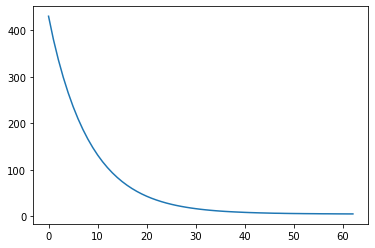

In [29]:
predtrain = np.argmax(cifarSVM.predict(trainX, normalize=True), axis=0)
predtest = np.argmax(cifarSVM.predict(testX, normalize=True), axis=0)
print("Final train accuracy: {:.2f}%\n Final test accuracy: {:.2f}%".format(100*cifarSVM.accuracy(predtrain, trainy), 100*cifarSVM.accuracy(predtest, testy)))
plt.plot(loss_cifarSVM);

CIFAR10 + SoftMax

In [33]:
cifarSM = SoftMax(10)
cifarSM.load(trainX, trainy, normalize=True)

In [34]:
loss_cifarSM = cifarSM.train(batch_size=256, epochs=200, alpha=.003, lambda_=.05, verbose=True, epsilon=1e-4)

Cost at epoch 0: 227.44
Cost at epoch 10: 124.98
Cost at epoch 20: 69.80
Cost at epoch 30: 39.35
Cost at epoch 40: 22.55
Cost at epoch 50: 13.29
Cost at epoch 60: 8.17
Cost at epoch 70: 5.35
Cost at epoch 80: 3.79
Cost at epoch 90: 2.92
Cost at epoch 100: 2.45
Cost at epoch 110: 2.18
Cost at epoch 120: 2.03
Cost at epoch 130: 1.95
Cost at epoch 140: 1.91
Cost at epoch 150: 1.88
Cost at epoch 160: 1.87
Cost at epoch 170: 1.86
Cost at epoch 180: 1.86
Cost at epoch 190: 1.85


In [35]:
predtrain = np.argmax(cifarSM.predict(trainX, normalize=True), axis=0)
predtest = np.argmax(cifarSM.predict(testX, normalize=True), axis=0)
print("Final train accuracy: {:.2f}%\n Final test accuracy: {:.2f}%".format(100*cifarSM.accuracy(predtrain, trainy), 100*cifarSM.accuracy(predtest, testy)))
plt.plot(loss_cifarSM);